In [1]:
import pandas as pd
import numpy as np
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Financial Data Filtering

### Task

Use Financial Statement data to predict Tax Shelters. Tax Sheltering is a method used by companies to avoid taxes. It allows companies to forego billions in taxes every year. The IRS has released historical Tax Shelter data, and we want to use a company's financial statements to predict Tax Shelters. Note that despite its cost, companies are rarely caught participating in a tax shelter. Let's begin by importing financial statement data from compustat and filtering that data.

In [92]:
stk=pd.read_csv('9c153c30dbfcdcb5.csv')

### Dropping Null Columns and Duplicate observations

Compustat puts out data in multiple formats, and for certain metrics is only able to get data on a small number of firms. Let's reduce down to the standard format, and only keep the columns that have sufficient data to impute a mean value for the column.

In [93]:
stk=stk[(stk['indfmt']=='INDL')&(stk['datafmt']=='STD')&(stk['consol']=='C')&(stk['popsrc']=='D')].reset_index(drop=True)

In [95]:
len(stk)*.8

114267.20000000001

In [96]:
skt=stk.dropna(thresh = 114267, axis = 1, inplace = True)

In [97]:
len(stk.columns)

158

In [98]:
len(stk)

142834

In [348]:
#This is just so we can reload it as needed
stk.to_csv('compustat.csv')

# Tax Data Formatting

In [345]:
df=pd.read_stata('tax_shelters.dta')

### Format data

This data was used in an experiment with a matched sample, and so we are only going to keep our treatment firms. Furthermore, for the matched sample, the observations were listed wide instead of long. In other words, there would be one observation, with multiple columns stating each time they had been caught. For our merges, we want to adjust our data so that it is long. In other words, we will give each firm-year observation its own entry in the data frame.

In [346]:
df=df[df['treatment']==1].reset_index(drop=True)

In [347]:
df2=df.dropna(subset=['revealyear1']).groupby('gvkey',as_index=False)['revealyear1'].mean()
df3=df.dropna(subset=['revealyear2']).groupby('gvkey',as_index=False)['revealyear2'].mean()
df5=df.dropna(subset=['revealyear3']).groupby('gvkey',as_index=False)['revealyear3'].mean()
df4=df2.append(df3).append(df5)

In [351]:
df4['revealyear1']=df4['revealyear1'].fillna(df4['revealyear2']).fillna(df4['revealyear3'])

In [352]:
df4=df4.dropna(subset=['revealyear1']).reset_index(drop=True)

In [353]:
df4=df4.drop(['revealyear2','revealyear3'],axis=1)

In [354]:
df4['treat']=1

In [355]:
df4=df4.sort_values(['gvkey']).reset_index(drop=True)

### Merging with Financial Data

Now that we have gotten our treatment list into a usable format, we are going to merge it with the financial data and create a new variable that tracks if a company has been fined previously (we believe that this might be predictive). Once we have gotten that variable, we will merge both it, and the tax data onto the financial data so that it is usable. We will then export the data so that if we want to come back to the project with a complete dataset we can.

In [371]:
df5=df4.groupby('gvkey',as_index=False)['revealyear1'].min().rename(columns={'revealyear1':'minyear'})

In [360]:
df4['gvkey']=pd.to_numeric(df4['gvkey'])

In [357]:
stk['datadate']=pd.to_datetime(stk['datadate'],format='%Y%m%d')

In [358]:
stk['year']=stk['datadate'].dt.year

In [359]:
stk['revealyear1']=stk['year']-1

In [361]:
stk2=pd.merge(df4,stk,on=['gvkey','revealyear1'],how='right')

In [374]:
stk2=pd.merge(df5,stk2,on='gvkey',how='right')

In [378]:
lis=list(stk2['revealyear1'])
lis2=list(stk2['minyear'])
lis3=[]
for x in range(0,len(lis)):
    if lis[x]>lis2[x]:
        lis3.append(1)
    else:
        lis3.append(0)
stk2['priortreat']=lis3

In [380]:
stk2['treat']=stk2['treat'].fillna(0)

In [381]:
stk2=stk2.drop(['indfmt','consol','popsrc','datafmt'],axis=1)

# Data Visualization

#### Basic Data Format

Let's start by looking at our data format

In [3]:
import seaborn as sns 
import matplotlib.pyplot as plt
stk2.head()

,Unnamed: 0,gvkey,minyear,revealyear1,treat,datadate,fyear,tic,cusip,curcd,...,prch_f,prcl_f,adjex_f,rank,au,auop,idbflag,sic,year,priortreat
0,0,1300,1996.0,1996.0,1.0,1997-12-31,1997.0,HON,438516106,USD,...,47.1250,31.625,1.0,1.0,7.0,1.0,B,9997,1997,0
1,1,1300,1996.0,1997.0,1.0,1998-12-31,1998.0,HON,438516106,USD,...,47.5625,32.625,1.0,1.0,7.0,1.0,B,9997,1998,1
2,2,1300,1996.0,1993.0,0.0,1994-12-31,1994.0,HON,438516106,USD,...,40.6875,30.375,2.0,1.0,7.0,4.0,B,9997,1994,0
3,3,1300,1996.0,1994.0,0.0,1995-12-31,1995.0,HON,438516106,USD,...,49.8750,33.375,2.0,1.0,7.0,4.0,B,9997,1995,0
4,4,1300,1996.0,1995.0,0.0,1996-12-31,1996.0,HON,438516106,USD,...,74.3750,47.125,2.0,1.0,7.0,1.0,B,9997,1996,0


Cool, so we have Firm-Year obervations. Let's continue by seeing which columns we have. As you can tell below, we have 160 columns of various financial statement variables.

In [6]:
stk2.columns[:100]

Index(['Unnamed: 0', 'gvkey', 'minyear', 'revealyear1', 'treat', 'datadate',
       'fyear', 'tic', 'cusip', 'curcd', 'final', 'fyr', 'pddur', 'scf', 'src',
       'upd', 'acchg', 'aco', 'acox', 'ao', 'aoloch', 'aox', 'ap', 'at',
       'bkvlps', 'caps', 'capx', 'capxv', 'ceq', 'ceql', 'ceqt', 'ch', 'che',
       'chech', 'cogs', 'csho', 'cshpri', 'cstk', 'cstkcv', 'cstke', 'dcpstk',
       'dcvt', 'dd1', 'dlc', 'dltis', 'dltr', 'dltt', 'do', 'dp', 'dpc',
       'dudd', 'dv', 'dvc', 'dvp', 'dvt', 'ebit', 'ebitda', 'epsfi', 'epsfx',
       'epspi', 'epspx', 'esopct', 'esopdlt', 'esopt', 'exre', 'fiao', 'fincf',
       'fopo', 'gp', 'ib', 'ibadj', 'ibc', 'ibcom', 'icapt', 'intan', 'invt',
       'itcb', 'ivaco', 'ivaeq', 'ivao', 'ivch', 'ivncf', 'ivst', 'lco',
       'lcox', 'lo', 'lse', 'lt', 'mib', 'mibt', 'mii', 'msa', 'ni', 'niadj',
       'nopi', 'nopio', 'np', 'oancf', 'oiadp', 'oibdp'],
      dtype='object')

In [7]:
stk2.columns[100:]

Index(['opeps', 'pi', 'ppent', 'pstk', 'pstkc', 'pstkl', 'pstkn', 'pstkr',
       'pstkrv', 're', 'reajo', 'recco', 'rect', 'recta', 'reuna', 'revt',
       'sale', 'seq', 'siv', 'spi', 'sppiv', 'sstk', 'tstk', 'tstkc', 'tstkn',
       'tstkp', 'txdb', 'txdc', 'txditc', 'txp', 'txt', 'xi', 'xido', 'xidoc',
       'xopr', 'cik', 'costat', 'naicsh', 'sich', 'cshtr_c', 'dvpsp_c',
       'dvpsx_c', 'prcc_c', 'prch_c', 'prcl_c', 'adjex_c', 'cshtr_f',
       'dvpsp_f', 'dvpsx_f', 'prcc_f', 'prch_f', 'prcl_f', 'adjex_f', 'rank',
       'au', 'auop', 'idbflag', 'sic', 'year', 'priortreat'],
      dtype='object')

#### Correlation Analysis

Let's next try and better understand these columns by seeing if we have any essentially equivalent variables. It appears that we have quite a few who are extremely correlated. Now while we could drop the variables, we will instead use some kind of dimmensionality reduction to handle the problem.

In [9]:
corrs = stk2.corr().abs()
corrs1 = corrs.unstack().drop_duplicates()
strongest = corrs1.sort_values(kind="quicksort", ascending = False)
strongest1 = pd.DataFrame(strongest)
temp = strongest1.index.values
first_cols = [i[0] for i in temp]
second_cols = [j[1] for j in temp]
total_cols_corr = list(set(first_cols[:25] + second_cols[:25]))
strongest.head(10)

Unnamed: 0  Unnamed: 0    1.000000
ebit        oiadp         1.000000
epsfi       epspi         1.000000
epsfx       epspx         1.000000
ib          ibc           0.999958
tstk        tstkc         0.999928
prcl_c      prcl_f        0.999920
prcc_c      prcc_f        0.999906
adjex_c     adjex_f       0.999903
prch_c      prch_f        0.999737
dtype: float64

Let's try and visualize how extensive this problem might be by using a heatmap

Text(0.5, 1.0, 'Independent Variable Correlations Heatmap')

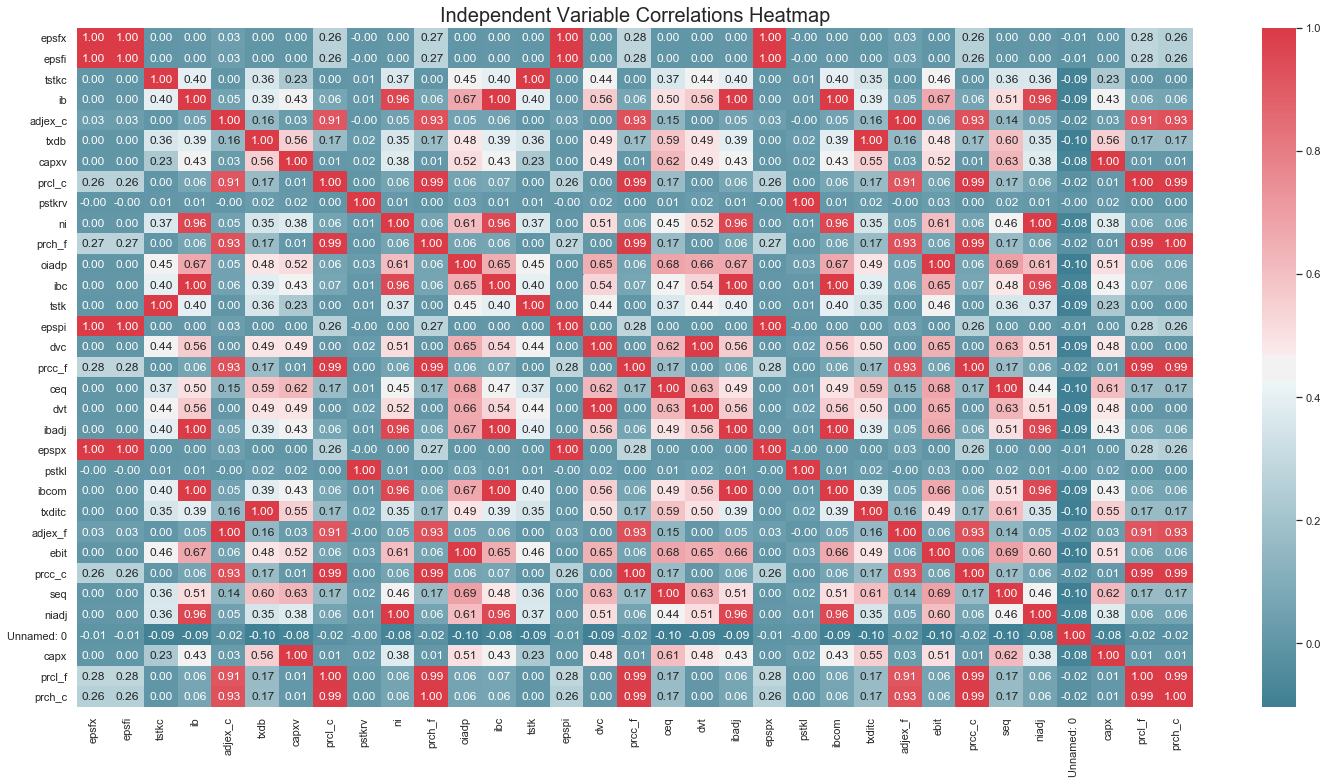

In [11]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
corr = stk2[total_cols_corr].corr()
sns.set(font_scale=1)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(25, 12.5))
sns.heatmap(corr, cmap=cmap, annot=True, ax=ax, fmt='.2f')
plt.title('Independent Variable Correlations Heatmap',fontsize=20)

Next we can check how correlated our variables are to the treatment itself. As we can see, some of the most correlated variables are treasury stock(tstk), taxes payable(txt), etc. We can also see that things like earnings (ebit) are also fairly important. This gives us some important insights. First, many of our variables most correlated to treatment are highly collinear (tstkc & tstkn for example); meaning it is very important that we do dimmensionality reduction. Second, none of our variables is very correlated to treatment. This is important because it helps us set some expectations as to what we think the predictive power of the model will be.

In [34]:
print(corrs["treat"].sort_values(ascending=False).head(20))

treat     1.000000
tstkc     0.090956
tstk      0.090848
tstkn     0.090791
txt       0.089286
reuna     0.085953
gp        0.085731
ebit      0.084327
oiadp     0.083129
oibdp     0.081121
ebitda    0.081121
pi        0.081055
re        0.076840
dvt       0.073380
dvc       0.072824
ceq       0.071972
revt      0.071942
sale      0.071942
dv        0.071861
seq       0.070986
Name: treat, dtype: float64


#### Variables of Interest Analysis

Next, let's look and see what we can learn about some of these most correlated variables. First, let's look at treasury stock. As you can see, the total treasury stock seems to be bounded more towards 0 in the control group. This implies that truly large firms are more likely to be participating in a tax shelter (or at least more likely to get caught). Furthermore, not only do the means appear to be different, there appears to be much wider variance around the total treasury stock. Now as we continue to the other graphs, we see a very similar situation. The total assets, total earnings, gross profit, etc., all exhibit this same pattern, telling us that there is a type of firm that seems to be prone to this particular problem.

C:\Users\owner\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Total Treasury Stock')

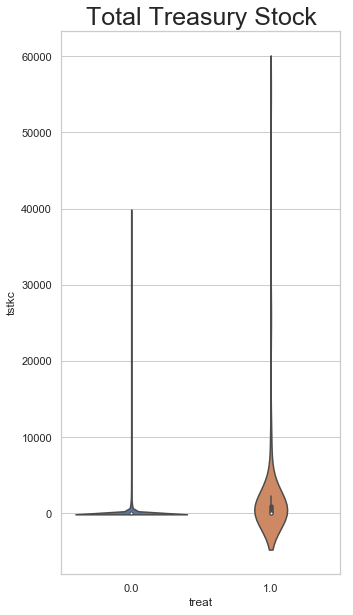

In [35]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
f, ax = plt.subplots(figsize=(5, 10))
sns.violinplot(x="treat", y="tstkc", data=stk2, size=6)
ax.set_title('Total Treasury Stock', size = 25)

Text(0.5, 1.0, 'Retained Earnings')

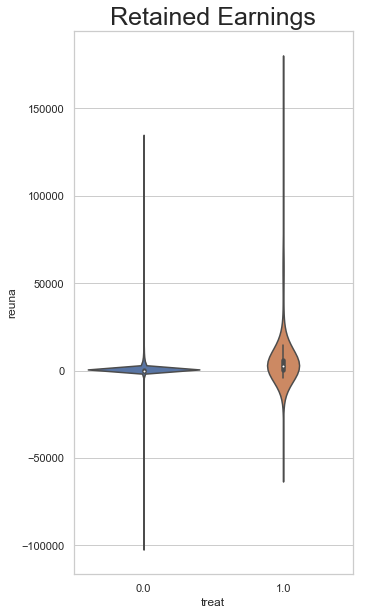

In [36]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
f, ax = plt.subplots(figsize=(5, 10))
sns.violinplot(x="treat", y="reuna", data=stk2, size=6)
ax.set_title('Retained Earnings', size = 25)

Text(0.5, 1.0, 'EBIT')

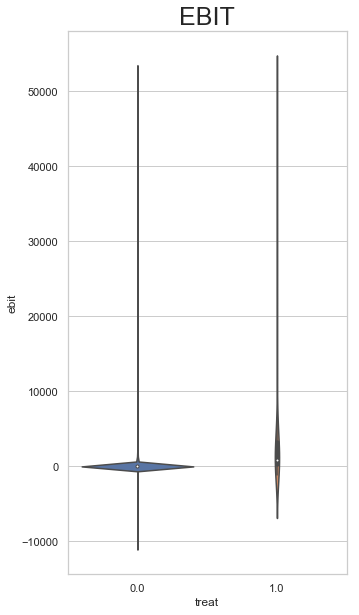

In [37]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
f, ax = plt.subplots(figsize=(5, 10))
sns.violinplot(x="treat", y="ebit", data=stk2, size=6)
ax.set_title('EBIT', size = 25)


C:\Users\Kevin Standridge\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Gross Profit')

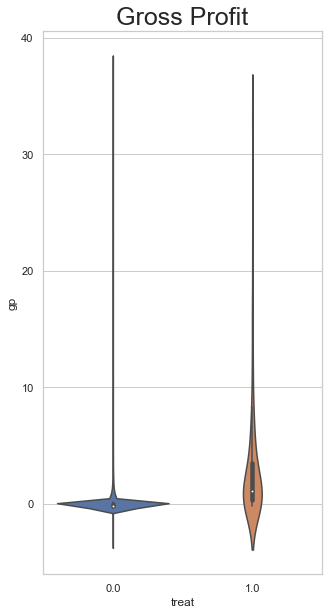

In [182]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
f, ax = plt.subplots(figsize=(5, 10))
sns.violinplot(x="treat", y="gp", data=stk2, size=6)
ax.set_title('Gross Profit', size = 25)


Text(0.5, 1.0, 'Total Assets')

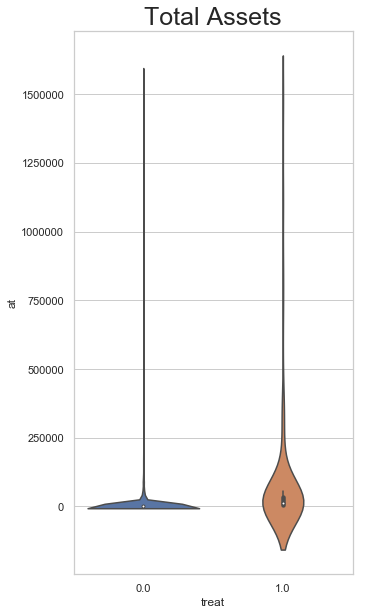

In [39]:
stk2['sich'].head()
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
f, ax = plt.subplots(figsize=(5, 10))
sns.violinplot(x="treat", y="at", data=stk2, size=6)
ax.set_title('Total Assets', size = 25)

# Data Cleaning and Prep

### Drop Identifier Variables

Now that we have gotten our data into a usable format, let's continue by getting rid of identifier variables that are not useful for predictions

In [69]:
stk2=stk2.drop(['Unnamed: 0','cusip','curcd','fyr','pddur','src','upd','final','cik', 'costat', 'naicsh','rank','idbflag'],axis=1)

In [70]:
stk2.columns

Index(['gvkey', 'minyear', 'revealyear1', 'treat', 'datadate', 'fyear', 'tic',
       'scf', 'acchg', 'aco',
       ...
       'dvpsx_f', 'prcc_f', 'prch_f', 'prcl_f', 'adjex_f', 'au', 'auop', 'sic',
       'year', 'priortreat'],
      dtype='object', length=147)

### Identifying Useful Features

Now let's take the most correlated with our treatment and see if we can find a few that we might want to interact for to regress on our treatment

In [71]:
variables=list(np.abs(stk2.corr()['treat']).sort_values(ascending=False).reset_index()['index'][1:])

In [72]:
variables[0:15]

['tstkc',
 'tstk',
 'tstkn',
 'txt',
 'reuna',
 'gp',
 'ebit',
 'oiadp',
 'ebitda',
 'oibdp',
 'pi',
 're',
 'dvt',
 'dvc',
 'ceq']

### Feature Engineering

Next, using some intuition from our financial variables and what is listed as our most correlated. So for example the amount of treasury stock (tstkc) and the amount of taxes (txt) that a company owes, seem to be very predictive. So we will interact these with other variables such as earnings before interest and taxes (ebit) or the amount of retained earnings (re). We feel that given the amount of training data that we have, we are highly worried that we simply will not have the degrees of freedom necessary to handle large numbers of features. With that said however, we believe these initial interactions will be useful

In [73]:
stk2['txtstkc']=stk2['txt']*stk2['tstkc']
stk2['gpstkc']=stk2['gp']*stk2['tstkc']
stk2['ebitstkc']=stk2['ebit']*stk2['tstkc']
stk2['reunatstkc']=stk2['reuna']*stk2['tstkc']

For the variables with the greatest correlation with the treatment, we also believe it could be important to scale them by the size of the firm so that they are more comparable across firms.

In [74]:
stk2['txtat']=stk2['txt']/stk2['at']
stk2['reunaat']=stk2['reuna']/stk2['at']
stk2['gpat']=stk2['gp']/stk2['at']
stk2['ebitat']=stk2['ebit']/stk2['at']
stk2['oiadpat']=stk2['oiadp']/stk2['at']
stk2['ebitda']=stk2['ebitda']/stk2['at']
stk2['oibdpat']=stk2['oibdp']/stk2['at']
stk2['piat']=stk2['pi']/stk2['at']
stk2['reat']=stk2['re']/stk2['at']

#### Variable Classification

The sic code variable, though it appears continuous, is actually and industry classifier. We will go ahead and groupy the variable into 48 industries, and then create 48 dummies.

In [75]:
def ffi48(row):
    if (100<=row['sic'] <=299) or (700<=row['sic']<=799) or (910<=row['sic']<=919) or (row['sic']==2048):
        ffi48=1
        ffi48_desc='Agric'
    elif (2000<=row['sic']<=2046) or (2050<=row['sic']<=2063) or (2070<=row['sic']<=2079)\
    or (2090<=row['sic']<=2092) or (row['sic']==2095) or (2098<=row['sic']<=2099):
        ffi48=2
        ffi48_desc='Food'
    elif (2064<=row['sic']<=2068) or (2086<=row['sic']<=2087) or (2096<=row['sic']<=2097):
        ffi48=3
        ffi48_desc='Soda'
    elif (row['sic']==2080) or (2082<=row['sic']<=2085):
        ffi48=4
        ffi48_desc='Beer'
    elif (2100<=row['sic']<=2199):
        ffi48=5
        ffi48_desc='Smoke'
    elif (920<=row['sic']<=999) or (3650<=row['sic']<=3652) or (row['sic']==3732) or (3930<=row['sic']<=3931) or (3940<=row['sic']<=3949):
        ffi48=6
        ffi48_desc='Toys'
    elif (7800<=row['sic']<=7833) or (7840<=row['sic']<=7841) or(row['sic']==7900)or (7910<=row['sic']<=7911) or (7920<=row['sic']<=7933)\
    or (7940<=row['sic']<=7949) or (row['sic']==7980) or (7990<=row['sic']<=7999):
        ffi48=7
        ffi48_desc='Fun'
    elif (2700<=row['sic']<=2749) or (2770<=row['sic']<=2771) or (2780<=row['sic']<=2799):
        ffi48=8
        ffi48_desc='Books'
    elif (row['sic']==2047) or (2391<=row['sic']<=2392) or (2510<=row['sic']<=2519) or (2590<=row['sic']<=2599) or (2840<=row['sic']<=2844)\
    or (3160<=row['sic']<=3161) or (3170<=row['sic']<=3172) or (3190<=row['sic']<=3199) or (row['sic']==3229) or (row['sic']==3260)\
    or (3262<=row['sic']<=3263) or (row['sic']==3269) or (3230<=row['sic']<=3231) or(3630<=row['sic']<=3639) or (3750<=row['sic']<=3751)\
    or (row['sic']==3800) or (3860<=row['sic']<=3861) or (3870<=row['sic']<=3873) or (3910<=row['sic']<=3911) or (3914<=row['sic']<=3915)\
    or (3960<=row['sic']<=3962) or (row['sic']==3991) or (row['sic']==3995):
        ffi48=9
        ffi48_desc='Hshld'
    elif (2300<=row['sic']<=2390) or (3020<=row['sic']<=3021) or (3100<=row['sic']<=3111)\
    or (3130<=row['sic']<=3131) or (3140<=row['sic']<=3151) or (3963<=row['sic']<=3965):
        ffi48=10
        ffi48_desc='Clths'
    elif (8000<=row['sic']<=8099):
        ffi48=11
        ffi48_desc='Hlth'
    elif (row['sic']==3693) or (3840<=row['sic']<=3851):
        ffi48=12
        ffi48_desc='MedEq'
    elif (2830<=row['sic']<=2831) or (2833<=row['sic']<=2836):
        ffi48=13
        ffi48_desc='Drugs'
    elif (2800<=row['sic']<=2829) or (2850<=row['sic']<=2879) or (2890<=row['sic']<=2899):
        ffi48=14
        ffi48_desc='Chems'
    elif (row['sic']==3031) or (row['sic']==3041) or (3050<=row['sic']<=3053) or (3060<=row['sic']<=3069) or (3070<=row['sic']<=3099):
        ffi48=15
        ffi48_desc='Rubbr'
    elif (2200<=row['sic']<=2284) or (2290<=row['sic']<=2295) or (2297<=row['sic']<=2299) or (2393<=row['sic']<=2395) or (2397<=row['sic']<=2399):
        ffi48=16
        ffi48_desc='Txtls'
    elif (800<=row['sic']<=899) or (2400<=row['sic']<=2439) or (2450<=row['sic']<=2459) or (2490<=row['sic']<=2499) or (2660<=row['sic']<=2661)\
    or (2950<=row['sic']<=2952) or (row['sic']==3200) or (3210<=row['sic']<=3211) or (3240<=row['sic']<=3241) or (3250<=row['sic']<=3259)\
    or (row['sic']==3261) or (row['sic']==3264) or (3270<=row['sic']<=3275) or (3280<=row['sic']<=3281) or (3290<=row['sic']<=3293)\
    or (3295<=row['sic']<=3299) or (3420<=row['sic']<=3433) or (3440<=row['sic']<=3442) or (row['sic']==3446) or (3448<=row['sic']<=3452)\
    or (3490<=row['sic']<=3499) or (row['sic']==3996):
        ffi48=17
        ffi48_desc='BldMt'
    elif (1500<=row['sic']<=1511) or (1520<=row['sic']<=1549) or (1600<=row['sic']<=1799):
        ffi48=18
        ffi48_desc='Cnstr'
    elif (row['sic']==3300) or (3310<=row['sic']<=3317) or (3320<=row['sic']<=3325) or (3330<=row['sic']<=3341) or(3350<=row['sic']<=3357)\
    or (3360<=row['sic']<=3379) or (3390<=row['sic']<=3399):
        ffi48=19
        ffi48_desc='Steel'
    elif (row['sic']==3400) or (3443<=row['sic']<=3444) or (3460<=row['sic']<=3479):
        ffi48=20
        ffi48_desc='FabPr'
    elif (3510<=row['sic']<=3536) or (row['sic']==3538) or (3540<=row['sic']<=3569)\
    or (3580<=row['sic']<=3582) or (3585<=row['sic']<=3586) or (3589<=row['sic']<=3599):
        ffi48=21
        ffi48_desc='Mach'
    elif (row['sic']==3600) or (3610<=row['sic']<=3613) or (3620<=row['sic']<=3621) or (3623<=row['sic']<=3629) or (3640<=row['sic']<=3646)\
    or (3648<=row['sic']<=3649) or (row['sic']==3660) or (3690<=row['sic']<=3692) or (row['sic']==3699):
            ffi48=22
            ffi48_desc='ElcEq'
    elif (row['sic']==2296) or (row['sic']==2396) or (3010<=row['sic']<=3011) or (row['sic']==3537) or (row['sic']==3647) or (row['sic']==3694)\
    or (row['sic']==3700) or (3710<=row['sic']<=3711) or (3713<=row['sic']<=3716) or (3790<=row['sic']<=3792) or (row['sic']==3799):
        ffi48=23
        ffi48_desc='Autos'
    elif (3720<=row['sic']<=3721) or (3723<=row['sic']<=3725) or (3728<=row['sic']<=3729):
        ffi48=24
        ffi48_desc='Aero'
    elif (3730<=row['sic']<=3731) or (3740<=row['sic']<=3743):
        ffi48=25
        ffi48_desc='Ships'
    elif (3760<=row['sic']<=3769) or (row['sic']==3795) or (3480<=row['sic']<=3489):
        ffi48=26
        ffi48_desc='Guns'
    elif (1040<=row['sic']<=1049):
        ffi48=27
        ffi48_desc='Gold'
    elif (1000<=row['sic']<=1039) or (1050<=row['sic']<=1119) or (1400<=row['sic']<=1499):
        ffi48=28
        ffi48_desc='Mines'
    elif (1200<=row['sic']<=1299):
        ffi48=29
        ffi48_desc='Coal'
    elif (row['sic']==1300) or (1310<=row['sic']<=1339) or (1370<=row['sic']<=1382) or (row['sic']==1389) or (2900<=row['sic']<=2912) or (2990<=row['sic']<=2999):
        ffi48=30
        ffi48_desc='Oil'
    elif (row['sic']==4900) or (4910<=row['sic']<=4911) or (4920<=row['sic']<=4925) or (4930<=row['sic']<=4932) or (4939<=row['sic']<=4942):
        ffi48=31
        ffi48_desc='Util'
    elif (row['sic']==4800) or (4810<=row['sic']<=4813) or (4820<=row['sic']<=4822) or (4830<=row['sic']<=4841) or (4880<=row['sic']<=4892) or (row['sic']==4899):
        ffi48=32
        ffi48_desc='Telcm'
    elif (7020<=row['sic']<=7021) or (7030<=row['sic']<=7033) or (row['sic']==7200) or (7210<=row['sic']<=7212) or (7214<=row['sic']<=7217)\
    or (7219<=row['sic']<=7221) or (7230<=row['sic']<=7231) or (7240<=row['sic']<=7241) or (7250<=row['sic']<=7251) or (7260<=row['sic']<=7299)\
    or (row['sic']==7395) or (row['sic']==7500) or (7520<=row['sic']<=7549) or (row['sic']==7600) or (row['sic']==7620)\
    or (7622<=row['sic']<=7623) or (7629<=row['sic']<=7631) or (7640<=row['sic']<=7641) or (7690<=row['sic']<=7699) or (8100<=row['sic']<=8499)\
    or (8600<=row['sic']<=8699) or (8800<=row['sic']<=8899) or (7510<=row['sic']<=7515):
        ffi48=33
        ffi48_desc='PerSv'
    elif (2750<=row['sic']<=2759) or (row['sic']==3993) or (row['sic']==7218) or (row['sic']==7300) or (7310<=row['sic']<=7342)\
    or (7349<=row['sic']<=7353) or (7359<=row['sic']<=7372) or (7374<=row['sic']<=7385) or (7389<=row['sic']<=7394) or (7396<=row['sic']<=7397)\
    or (row['sic']==7399) or (row['sic']==7519) or (row['sic']==8700) or (8710<=row['sic']<=8713) or (8720<=row['sic']<=8721) \
    or (8730<=row['sic']<=8734) or (8740<=row['sic']<=8748) or (8900<=row['sic']<=8911) or (8920<=row['sic']<=8999) or (4220<=row['sic']<=4229):
        ffi48=34
        ffi48_desc='BusSv'
    elif (3570<=row['sic']<=3579) or (3680<=row['sic']<=3689) or (row['sic']==3695) or (row['sic']==7373):
        ffi48=35
        ffi48_desc='Comps'
    elif (row['sic']==3622) or (3661<=row['sic']<=3666) or (3669<=row['sic']<=3679) or (row['sic']==3810) or (row['sic']==3812):
        ffi48=36
        ffi48_desc='Chips'
    elif (row['sic']==3811) or (3820<=row['sic']<=3827) or (3829<=row['sic']<=3839):
        ffi48=37
        ffi48_desc='LabEq'
    elif (2520<=row['sic']<=2549) or (2600<=row['sic']<=2639) or (2670<=row['sic']<=2699) or (2760<=row['sic']<=2761) or (3950<=row['sic']<=3955):
        ffi48=38
        ffi48_desc='Paper'
    elif (2440<=row['sic']<=2449) or (2640<=row['sic']<=2659) or (3220<=row['sic']<=3221) or (3410<=row['sic']<=3412):
        ffi48=39
        ffi48_desc='Boxes'
    elif (4000<=row['sic']<=4013) or (4040<=row['sic']<=4049) or (row['sic']==4100)  or (4110<=row['sic']<=4121) or (4130<=row['sic']<=4131)\
    or (4140<=row['sic']<=4142) or (4150<=row['sic']<=4151) or (4170<=row['sic']<=4173) or (4190<=row['sic']<=4200)\
    or (4210<=row['sic']<=4219) or (4230<=row['sic']<=4231) or (4240<=row['sic']<=4249) or (4400<=row['sic']<=4700) or (4710<=row['sic']<=4712)\
    or (4720<=row['sic']<=4749) or (row['sic']==4780) or (4782<=row['sic']<=4785) or (row['sic']==4789):
        ffi48=40
        ffi48_desc='Trans'
    elif (row['sic']==5000) or (5010<=row['sic']<=5015) or (5020<=row['sic']<=5023) or (5030<=row['sic']<=5060) or (5063<=row['sic']<=5065)\
    or (5070<=row['sic']<=5078) or (5080<=row['sic']<=5088) or (5090<=row['sic']<=5094) or (5099<=row['sic']<=5100)\
    or (5110<=row['sic']<=5113) or (5120<=row['sic']<=5122) or (5130<=row['sic']<=5172) or (5180<=row['sic']<=5182) or (5190<=row['sic']<=5199):
        ffi48=41
        ffi48_desc='Whlsl'
    elif (row['sic']==5200) or (5210<=row['sic']<=5231) or (5250<=row['sic']<=5251) or (5260<=row['sic']<=5261) or (5270<=row['sic']<=5271)\
    or (row['sic']==5300) or (5310<=row['sic']<=5311) or (row['sic']==5320) or (5330<=row['sic']<=5331) or (row['sic']==5334)\
    or (5340<=row['sic']<=5349) or (5390<=row['sic']<=5400) or (5410<=row['sic']<=5412) or (5420<=row['sic']<=5469) or (5490<=row['sic']<=5500)\
    or (5510<=row['sic']<=5579) or (5590<=row['sic']<=5700) or (5710<=row['sic']<=5722) or (5730<=row['sic']<=5736) or (5750<=row['sic']<=5799)\
    or (row['sic']==5900) or (5910<=row['sic']<=5912) or (5920<=row['sic']<=5932) or (5940<=row['sic']<=5990) or (5992<=row['sic']<=5995) or (row['sic']==5999):
        ffi48=42
        ffi48_desc='Rtail'
    elif (5800<=row['sic']<=5829) or (5890<=row['sic']<=5899) or (row['sic']==7000) or (7010<=row['sic']<=7019) or (7040<=row['sic']<=7049) or (row['sic']==7213):
        ffi48=43
        ffi48_desc='Meals'
    elif (row['sic']==6000) or (6010<=row['sic']<=6036) or (6040<=row['sic']<=6062) or (6080<=row['sic']<=6082) or (6090<=row['sic']<=6100)\
    or (6110<=row['sic']<=6113) or (6120<=row['sic']<=6179) or (6190<=row['sic']<=6199):
        ffi48=44
        ffi48_desc='Banks'
    elif (row['sic']==6300) or (6310<=row['sic']<=6331) or (6350<=row['sic']<=6351) or (6360<=row['sic']<=6361) or (6370<=row['sic']<=6379) or (6390<=row['sic']<=6411):
        ffi48=45
        ffi48_desc='Insur'
    elif (row['sic']==6500) or (row['sic']==6510) or (6512<=row['sic']<=6515) or (6517<=row['sic']<=6532) or (6540<=row['sic']<=6541)\
    or (6550<=row['sic']<=6553) or (6590<=row['sic']<=6599) or (6610<=row['sic']<=6611):
        ffi48=46
        ffi48_desc='RlEst'
    elif (6200<=row['sic']<=6299) or (row['sic']==6700) or (6710<=row['sic']<=6726) or (6730<=row['sic']<=6733) or (6740<=row['sic']<=6779)\
    or (6790<=row['sic']<=6795) or (6798<=row['sic']<=6799):
        ffi48=47
        ffi48_desc='Fin'
    elif (4950<=row['sic']<=4961) or (4970<=row['sic']<=4971) or (4990<=row['sic']<=4991) or (row['sic']==9999):
        ffi48=48
        ffi48_desc='Other'
    else:
        ffi48=np.nan
        ffi48_desc=''
    return pd.Series({'sic': row['sic'], 'ffi48': ffi48, 'ffi48_desc': ffi48_desc})


In [76]:
_sic = stk2['sic'].unique()
_sicff = pd.DataFrame(_sic).rename(columns={0:'sic'})
_sicff = _sicff.apply(ffi48, axis=1)
stk2 = pd.merge(stk2, _sicff, how='left', on=['sic'])

Let's look and see how our treatments are distributed across industries and years to see if we can spot any patterns. Unfortunately, we see some clumping, but no clear patterns emerge.

C:\Users\Kevin Standridge\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Treatment by Industry')

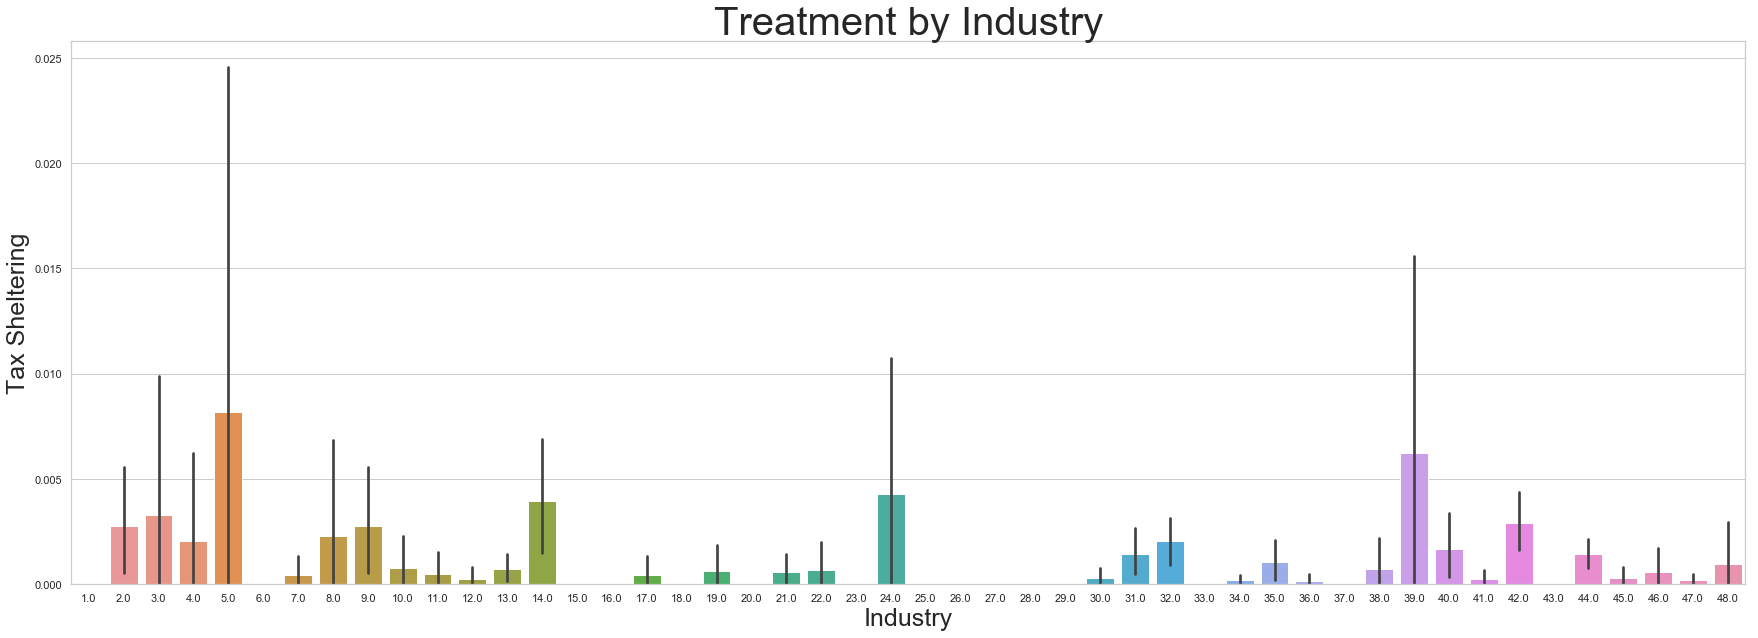

In [77]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(x="ffi48", y="treat", data=stk2)
ax.set_xlabel("Industry", fontsize=25)
ax.set_ylabel("Tax Sheltering", fontsize=25)
ax.set_title('Treatment by Industry', size = 40)

Comparatively, the smoking, chemical, Aero, and boxing industries stand out as having the most tax sheltering. 

Text(0.5, 1.0, 'Firms by Industry')

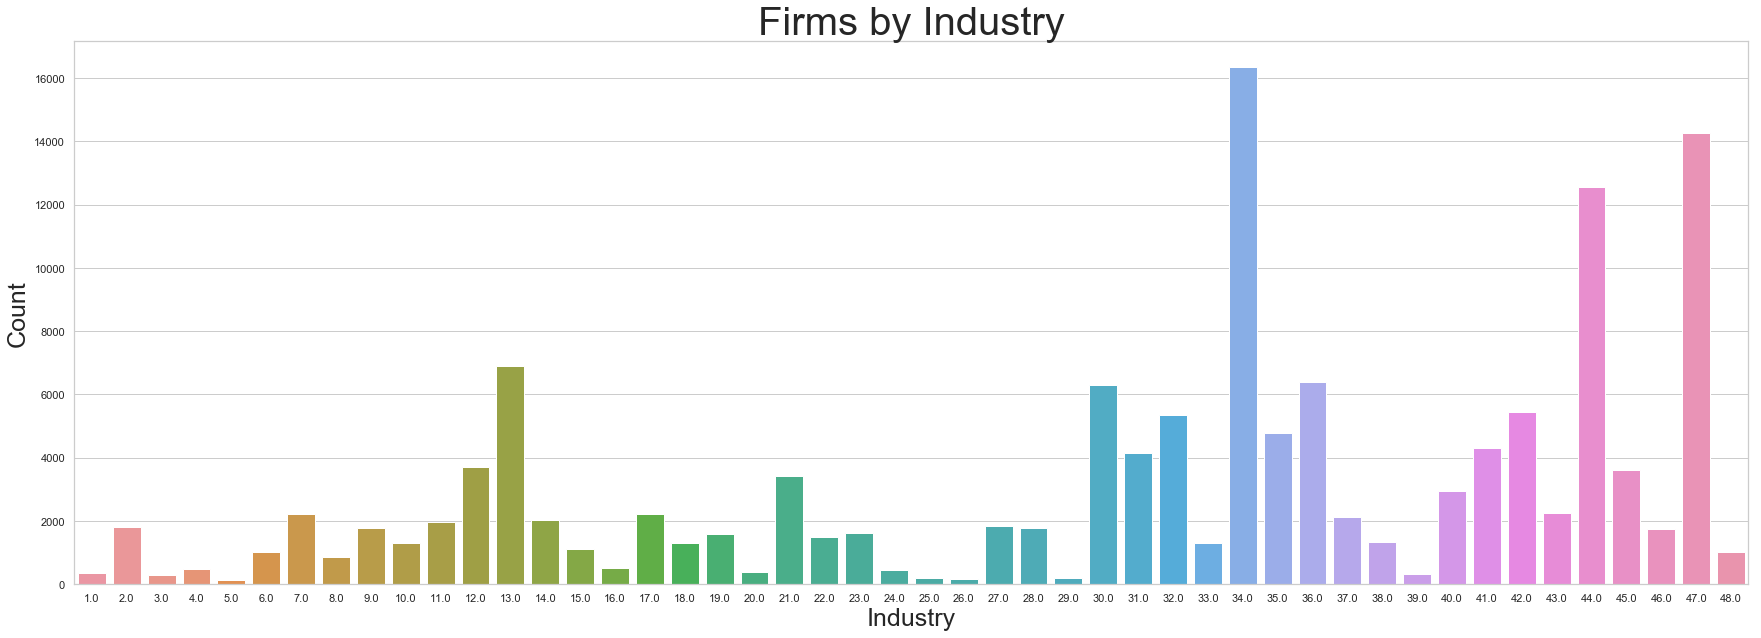

In [78]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
f, ax = plt.subplots(figsize=(30, 10))
sns.countplot(x="ffi48", data=stk2)
ax.set_xlabel("Industry", fontsize=25)
ax.set_ylabel("Count", fontsize=25)
ax.set_title('Firms by Industry', size = 40)

Text(0.5, 1.0, 'Treatment by Year')

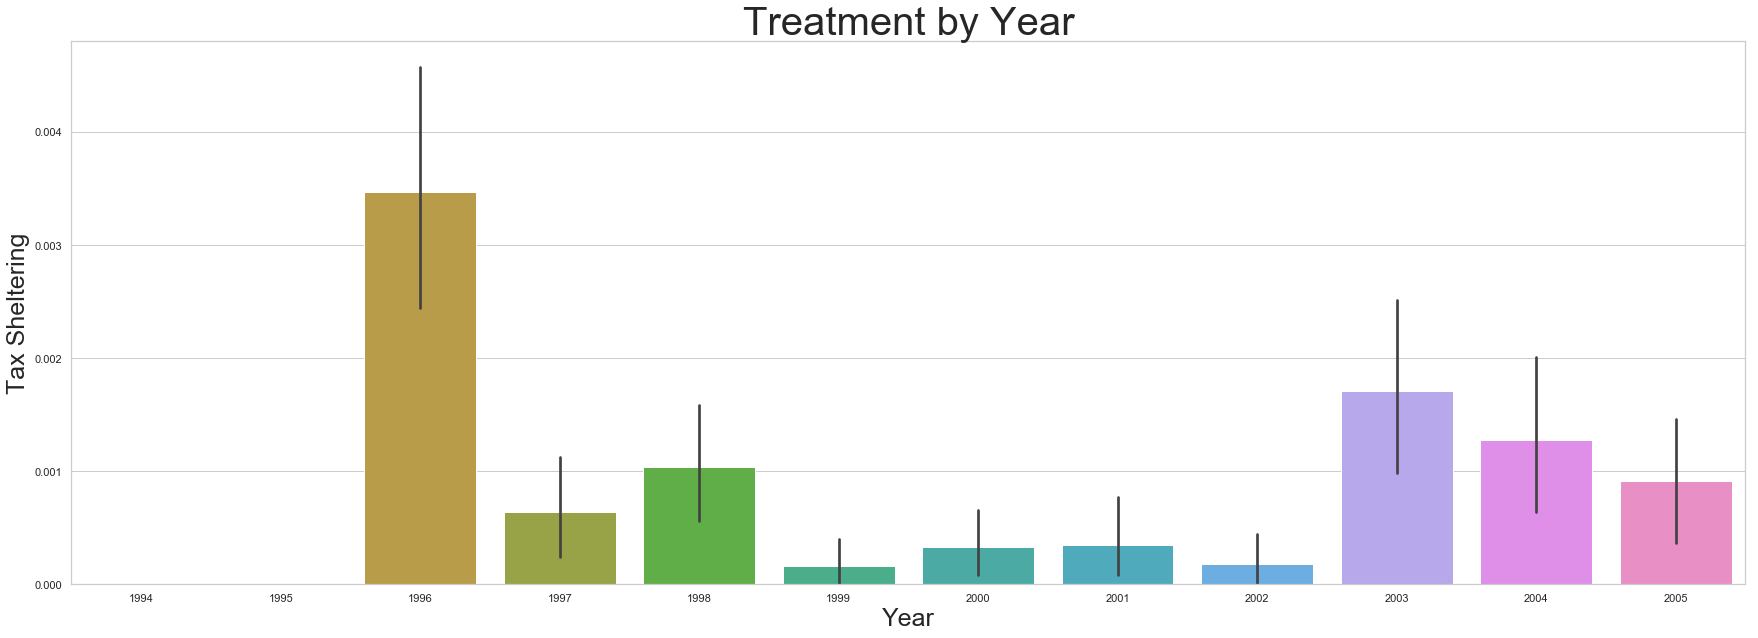

In [79]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(x="year", y="treat", data=stk2)
ax.set_xlabel("Year", fontsize=25)
ax.set_ylabel("Tax Sheltering", fontsize=25)
ax.set_title('Treatment by Year', size = 40)

#### Dummies and Final Cleaning

Now drop the useless sich variable, and get dummies for the industries themselves

In [81]:
stk2=stk2.drop('sich',1)

In [82]:
a=pd.get_dummies(stk2['ffi48'])
stk2[a.columns]=a

Let's reset our variables and make sure that everything works before we continue

In [83]:
stk2.columns[:100]

Index(['gvkey', 'minyear', 'revealyear1', 'treat', 'datadate', 'fyear', 'tic',
       'scf', 'acchg', 'aco', 'acox', 'ao', 'aoloch', 'aox', 'ap', 'at',
       'bkvlps', 'caps', 'capx', 'capxv', 'ceq', 'ceql', 'ceqt', 'ch', 'che',
       'chech', 'cogs', 'csho', 'cshpri', 'cstk', 'cstkcv', 'cstke', 'dcpstk',
       'dcvt', 'dd1', 'dlc', 'dltis', 'dltr', 'dltt', 'do', 'dp', 'dpc',
       'dudd', 'dv', 'dvc', 'dvp', 'dvt', 'ebit', 'ebitda', 'epsfi', 'epsfx',
       'epspi', 'epspx', 'esopct', 'esopdlt', 'esopt', 'exre', 'fiao', 'fincf',
       'fopo', 'gp', 'ib', 'ibadj', 'ibc', 'ibcom', 'icapt', 'intan', 'invt',
       'itcb', 'ivaco', 'ivaeq', 'ivao', 'ivch', 'ivncf', 'ivst', 'lco',
       'lcox', 'lo', 'lse', 'lt', 'mib', 'mibt', 'mii', 'msa', 'ni', 'niadj',
       'nopi', 'nopio', 'np', 'oancf', 'oiadp', 'oibdp', 'opeps', 'pi',
       'ppent', 'pstk', 'pstkc', 'pstkl', 'pstkn', 'pstkr'],
      dtype='object')

In [84]:
stk2.columns[101:200]

Index([        're',      'reajo',      'recco',       'rect',      'recta',
            'reuna',       'revt',       'sale',        'seq',        'siv',
              'spi',      'sppiv',       'sstk',       'tstk',      'tstkc',
            'tstkn',      'tstkp',       'txdb',       'txdc',     'txditc',
              'txp',        'txt',         'xi',       'xido',      'xidoc',
             'xopr',    'cshtr_c',    'dvpsp_c',    'dvpsx_c',     'prcc_c',
           'prch_c',     'prcl_c',    'adjex_c',    'cshtr_f',    'dvpsp_f',
          'dvpsx_f',     'prcc_f',     'prch_f',     'prcl_f',    'adjex_f',
               'au',       'auop',        'sic',       'year', 'priortreat',
          'txtstkc',     'gpstkc',   'ebitstkc', 'reunatstkc',      'txtat',
          'reunaat',       'gpat',     'ebitat',    'oiadpat',    'oibdpat',
             'piat',       'reat',      'ffi48', 'ffi48_desc',          1.0,
                2.0,          3.0,          4.0,          5.0,          6.0,

In [85]:
stk2.columns[201:]

Index([42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0], dtype='object')

In [86]:
continuous=['scf', 'acchg', 'aco', 'acox', 'ao', 'aoloch', 'aox', 'ap', 'at',
       'bkvlps', 'caps', 'capx', 'capxv', 'ceq', 'ceql', 'ceqt', 'ch', 'che',
       'chech', 'cogs', 'csho', 'cshpri', 'cstk', 'cstkcv', 'cstke', 'dcpstk',
       'dcvt', 'dd1', 'dlc', 'dltis', 'dltr', 'dltt', 'do', 'dp', 'dpc',
       'dudd', 'dv', 'dvc', 'dvp', 'dvt', 'ebit', 'ebitda', 'epsfi', 'epsfx',
       'epspi', 'epspx', 'esopct', 'esopdlt', 'esopt', 'exre', 'fiao', 'fincf',
       'fopo', 'gp', 'ib', 'ibadj', 'ibc', 'ibcom', 'icapt', 'intan', 'invt',
       'itcb', 'ivaco', 'ivaeq', 'ivao', 'ivch', 'ivncf', 'ivst', 'lco',
       'lcox', 'lo', 'lse', 'lt', 'mib', 'mibt', 'mii', 'msa', 'ni', 'niadj',
       'nopi', 'nopio', 'np', 'oancf', 'oiadp', 'oibdp', 'opeps', 'pi',
       'ppent', 'pstk', 'pstkc', 'pstkl', 'pstkn', 'pstkr','pstkrv',         
            're',      'reajo',      'recco',       'rect',
            'recta',      'reuna',       'revt',       'sale',        'seq',
              'siv',        'spi',      'sppiv',       'sstk',       'tstk',
            'tstkc',      'tstkn',      'tstkp',       'txdb',       'txdc',
           'txditc',        'txp',        'txt',         'xi',       'xido',
            'xidoc',       'xopr',     'cshtr_c',    'dvpsp_c',
          'dvpsx_c',     'prcc_c',     'prch_c',     'prcl_c',    'adjex_c',
          'cshtr_f',    'dvpsp_f',    'dvpsx_f',     'prcc_f',     'prch_f',
           'prcl_f',    'adjex_f',         'au',       'auop',
            'txtstkc',     'gpstkc',   'ebitstkc', 'reunatstkc','txtat',
          'reunaat',       'gpat',     'ebitat',    'oiadpat',    'oibdpat',
             'piat',       'reat'
           ]

In [87]:
indicator=[ 1.0,          2.0,          3.0,
                4.0,          5.0,          6.0,          7.0,          8.0,
                9.0,         10.0,         11.0,         12.0,         13.0,
               14.0,         15.0,         16.0,         17.0,         18.0,
               19.0,         20.0,         21.0,         22.0,         23.0,
               24.0,         25.0,         26.0,         27.0,         28.0,
               29.0,         30.0,         31.0,         32.0,         33.0,
               34.0,         35.0,         36.0,         37.0,         38.0,
               39.0,         40.0,         41.0,         42.0,      a   43.0,
               44.0,         45.0,         46.0,         47.0,         48.0,
          'priortreat']

In [105]:
stk2[continuous]=stk2[continuous].replace([np.inf,-np.inf],np.nan)

### Normalize Variables

In [109]:
for x in continuous:
    stk2[x]=stk2[x].fillna(stk2[x].mean())
    stk2[x]=(stk2[x]-stk2[x].mean())/stk2[x].std()

In [110]:
variables=continuous+indicator

In [111]:
X=stk2[variables]
y=stk2['treat']

Let's just make sure that we did not get any columns will a 0 standard deviation that will cause us problems later

In [112]:
X=X.replace([np.inf,-np.inf],np.nan)
for x in variables:
    X[x]=X[x].fillna(X[x].mean())

In [113]:
len(X.columns)

197

# Dimensionality Reduction

With the low number of treatment observations, one of our big problems is going to be that we have the curse of dimmensionality. In other words, we do not have sufficient degrees of freedom to handle our number of features. At the same time, those features have a lot of predictive value, and we don't want to lose that. To solve this problem, we are going to use a PCA to reduce our feature set. The PCA forms a singular value decomposition that forms a series of Eigenvectors, which maximize the variance explained in our data. PCA is not an exact science, and so will graphically look at the variance explanation to try and find a kink point for explanatory power without overfitting.

As can be seen in the graph below, we have diminishing returns to adding additional features, but it looks like we should be able to explain about 95% of our data's variance through 62 features, and so we will begin with that to try on our model.

Text(0, 0.5, 'Explanation of Variance')

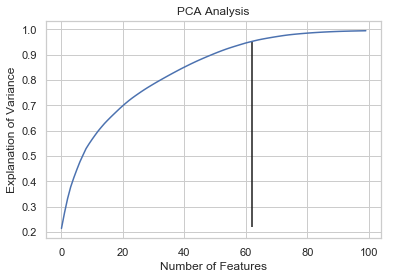

In [118]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0.22,ymax=cum_ratio[62],x=62)
plt.title('PCA Analysis')
plt.xlabel('Number of Features')
plt.ylabel('Explanation of Variance')

In [119]:
index_96 = np.argmax(cum_ratio >= 0.95)
print(index_96)
print(cum_ratio[index_96])

62
0.9527217539797382


In [120]:
pca = PCA(n_components=59)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(142834, 59)


In [121]:
X=pd.DataFrame(X_pca)

# Modeling

### Train Test Split

In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.75, test_size=0.25)

### Random Under Sampling

Now we noticed from the data visualization that there are very few treatment observations, relative to our number of total observations. This makes it very important that we either under or over sample. Now idealy we would oversample here, because we have so few treatment observations. With that said, because we do not have the processing power to run the models at that higher data level, we have to make due with under sampling. Under sampling should still do better than simply taking the data as is.

In [123]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

### Evaluation

In any classification problem, especially with unbalanced data, the balance between precision and recall becomes essential. We need to decide how important it is for us to guess which firms are participating in Tax Shelters, while also trying to minimize the number of firms that the IRS audits. We are going to use two metrics to evaluate each of our models, and then decide on the best one based on that. The first metric we will use is the Cohen Kappa Score, because the Cohen Kappa Score measures the incremental accuracy over random accuracy. This is essential because this represents the incremental value of the model to the IRS. Second, because we are not just interested in incremental accuracy, but also the balance between precision and recall in our models, we are going to look at the f1 score for each of these models. Ideally, the top model will maximize both characteristics, but if not, we will need to create a balance between the two.

In [124]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score

### Models

#### Logistic Regression

This is basic linear regression, just to examine how the model does in its most simple case. There is no regularization or hyper parameter tuning in this case.

In [125]:
from sklearn.linear_model import LogisticRegression
clf4 = LogisticRegression().fit(X_resampled, y_resampled)
predictions=clf4.predict(X_test)
print("Cohen Kappa: {}".format(cohen_kappa_score(predictions,y_test)))
print("F1 Score: {}".format(f1_score(predictions,y_test,average='macro')))

Cohen Kappa: 0.013491108614190783
F1 Score: 0.4816787811127065


#### Logistic Regression Cross Validated

This is the same as the model above, we are simply cross validating the regularization parameter. Note that in this case, the model does worse than if we do not cross validate the model. Why might this be, well the data necessary to train the model is larger in this case. We can therefore infer that the data used to train the model is more valuable than the regularization changes.

In [126]:
from sklearn.linear_model import LogisticRegressionCV

In [127]:
clf3 = LogisticRegressionCV(cv=5, scoring='f1').fit(X_resampled, y_resampled)
predictions=clf3.predict(X_test)
print("Cohen Kappa: {}".format(cohen_kappa_score(predictions,y_test)))
print("F1 Score: {}".format(f1_score(predictions,y_test,average='macro')))

Cohen Kappa: 0.01228076989606608
F1 Score: 0.4797931068207248


#### Random Forest Classifier

Next, we will try a random forest classifier to see how it does. A random forest classifier "bags" our data (it randomly samples with replacement, similar to bootstrapping), and creates split points that split the data into smaller and smaller categories at various nodes. The bagging allows for various different "decision trees" to be trained simultaneously. The model then combines our predictions and tells us which model produced the highest score. Not that this model (perhaps due to the unbalanced nature of the data out of sample), performed worse than linear regression.

In [128]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [1000, 2500, 5000]
max_depth = [1, 5, 10]
class_weights = ['balanced', None]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for wgt in class_weights:
            print(est, depth, wgt)
            clf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            clf.fit(X_resampled, y_resampled)
            f1 = f1_score(y_resampled, np.argmax(clf.oob_decision_function_ , 1))
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, wgt)

1000 1 balanced
1000 1 None
1000 5 balanced
1000 5 None
1000 10 balanced
1000 10 None
2500 1 balanced
2500 1 None
2500 5 balanced
2500 5 None
2500 10 balanced
2500 10 None
5000 1 balanced
5000 1 None
5000 5 balanced
5000 5 None
5000 10 balanced
5000 10 None


In [129]:
clf2 = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1], class_weight=best_params[2])
clf2.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [130]:
predictions = clf2.predict(X_test)
print("Cohen Kappa: {}".format(cohen_kappa_score(predictions,y_test)))
print("F1 Score: {}".format(f1_score(predictions,y_test,average='macro')))

Cohen Kappa: 0.012949302489119408
F1 Score: 0.47835713844560945


#### Gradient Boosted Classifier

Gradient Boosting is similar to a Random Forest in that it too creates decision trees, which split the data to try and find optimal splits. The main difference between the two however, is that a Gradient Boosted Classifier will train all of its trees sequentially, whereas a Random Forest will train all of its trees simultaneously. Graident Boosting does this so that it can put more weight on missed observations, in the hopes that the model will learn more over time.
<br>
<br>
Unfortunately however, this particular model does not do a good job of classifying our data. As can be seen, it performs even worse than the Random Forest. We attribute this to overfitting the model. Unfortunately, with so few test observations, it is very difficult to prevent overfitting with a Gradient Booosted Classifier.

In [131]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = [1000, 2500, 5000]
max_depth = [1, 5, 10]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for wgt in class_weights:
            print(est, depth, wgt)
            clf = GradientBoostingClassifier(learning_rate=.01,n_estimators=est, max_depth=depth)
            clf.fit(X_resampled, y_resampled)
            f1 = f1_score(y_resampled, clf.predict(X_resampled))
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, wgt)

1000 1 balanced
1000 1 None
1000 5 balanced
1000 5 None
1000 10 balanced
1000 10 None
2500 1 balanced
2500 1 None
2500 5 balanced
2500 5 None
2500 10 balanced
2500 10 None
5000 1 balanced
5000 1 None
5000 5 balanced
5000 5 None
5000 10 balanced
5000 10 None


In [132]:
clf = GradientBoostingClassifier(learning_rate=.01,n_estimators=best_params[0], max_depth=best_params[1])
clf.fit(X_resampled, y_resampled)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [133]:
predictions = clf.predict(X_test)
print("Cohen Kappa: {}".format(cohen_kappa_score(predictions,y_test)))
print("F1 Score: {}".format(f1_score(predictions,y_test,average='macro')))

Cohen Kappa: 0.0089165669952177
F1 Score: 0.4646606550359199


#### Stacked Classifier

Finally, we are going to attempt to stack our classifiers into a single model to see if the classfiers are perhaps correctly classifying certain types of data, but poorly classifying other types of data. When we stack models, we get the ombined information of each model, but do so at the expense of further loss in degrees of freedom. Given our data, it is no surprise that our Stacked Classifier performs worse than the logistic regressions. We are already overfitting with the Random Forest and Gradient Boosted Classifier, and further stacking does not help the problem.

In [134]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf, clf2, clf3, clf4], 
                          meta_classifier=lr)

In [135]:
clf4=sclf.fit(X_resampled,y_resampled)

In [136]:
predictions = clf4.predict(X_test)
print("Cohen Kappa: {}".format(cohen_kappa_score(predictions,y_test)))
print("F1 Score: {}".format(f1_score(predictions,y_test,average='macro')))

Cohen Kappa: 0.008764284740115147
F1 Score: 0.4609509649800172


# Conclusion

#### Important Variables to the model

In [175]:
lis=[]
for x in range(0,len(clf3.coef_[0])):
    lis.append(clf3.coef_[0][x]*pca.components_[x])

In [176]:
new=pd.DataFrame(lis)
lis=[]
for y in new.columns:
    lis.append(new[y].sum())

In [177]:
new2=pd.DataFrame(lis)
new2['vars']=variables

In [178]:
new2[1]=new2[0].abs()

The top variables are:
<br>1. The amount of convertible debt the company has.
<br>2. The common shares that are outstanding.
<br>3. How they present their cashflow.
<br>4. Amount of deferred taxes.
<br>5. How many assets have they sold.

In [179]:
new2.sort_values(1,ascending=False).head(5)

,0,vars,1
26,-1.363307,dcvt,1.363307
25,-1.258774,dcpstk,1.258774
120,1.044528,cshtr_c,1.044528
127,1.041375,cshtr_f,1.041375
0,0.914567,scf,0.914567


Text(0.5, 1.0, 'Most Important Variables')

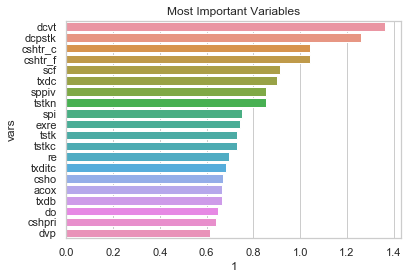

In [181]:
import seaborn as sns
new3=new2.sort_values(1,ascending=False).head(20)
sns.barplot(x=new3[1], y= new3['vars'])
plt.title('Most Important Variables')

#### Evaluation

The goal of the IRS is to predict tax shelters. The IRS has limited resources that it can devote to auditing companies. With the nearly 7000 companies outside the US, we tried to put ourselves in the place of the IRS and say what would they care about coming out of the model. It isn't the F1 score, or the cohen kappa score. The IRS cares about is if they listened to the model and it told the IRS to audit a series firms, what percentage of the total firms who are participating in tax shelters be captured? So let's find out!

In [187]:
predict2=clf4.predict_proba(X_test)

In [193]:
pd.DataFrame(predict2).head()

,0,1
0,0.932310,0.067690
1,0.932310,0.067690
2,0.932310,0.067690
3,0.932310,0.067690
4,0.306622,0.693378


As we begin our tests, it is important tthat we know what we would expect to find if our model were to be useless. In this case, we would expect that (given the data is 0.1% treatment), it would capture that amount of the treatment firms by random guessing.

In [172]:
y_test.sum()/len(y_test)

0.0010641574953093058

First, let's get our predicted probabilities. Second, there seems to be a standard value where model says it doesn't know what to do, and so just gives it a 93% chance of null. Let's start by taking all instances where the true value is different. Next, let's sort by the predicted probability and see what fraction of all of the total tax shelters (in the data set) it would capture. In this case, we have 12 years of data and so we will assume that the IRS would audit 100 per year.

In [188]:
newdf=pd.merge(pd.DataFrame(predict2)[pd.DataFrame(predict2)[1]!=pd.DataFrame(predict2)[1][0]].reset_index(),y_test.reset_index(drop=True).reset_index(),on='index')

In [213]:
newdf.sort_values(1,ascending=False)[:1200]['treat'].sum()/y_test.sum()

0.42105263157894735

To just emphasize how well the model does, consider the "default" prediction set that we noted above. Only about 0.02% of the the firms that were assigned to that value were actually treatment firms. This represents about 15.8% of total treatment firms.

In [165]:
newdf2=pd.merge(pd.DataFrame(predict2)[pd.DataFrame(predict2)[1]==pd.DataFrame(predict2)[1][0]].reset_index(),y_test.reset_index(drop=True).reset_index(),on='index')

In [215]:
newdf2['treat'].sum()/len(newdf2)

0.00020699648105982198

In [216]:
newdf2['treat'].sum()/y_test.sum()

0.15789473684210525

In conclusion, predicting tax shelters is a very difficult problem. There is not a long of available data, and the publicly available financial data is not extremely correlated with the tax shelter themselves. With that said, the model provides reasonable and useful predictions to the IRS in their audit procedures.